In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error

In [4]:
df_train = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet')
df_val = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet')

In [5]:
df_train.shape, df_val.shape

((68211, 20), (64809, 20))

In [7]:
df_train

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.90,1.0,0.5,4.03,0.0,None,1.0,24.18,1.0,1.0,2.75
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.70,1.0,0.5,2.64,0.0,None,1.0,15.84,1.0,1.0,0.00
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.20,1.0,0.5,1.94,0.0,None,1.0,11.64,1.0,1.0,0.00
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.50,0.5,1.5,1.70,0.0,None,1.0,10.20,1.0,1.0,0.00
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.00,0.5,1.5,0.00,0.0,None,1.0,8.00,1.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,None,NaN,49,62,NaN,4070.82,15.70,0.0,0.0,0.00,0.0,None,1.0,16.70,NaN,NaN,NaN
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,None,NaN,10,205,NaN,2.14,4.41,0.0,0.0,0.00,0.0,None,1.0,5.41,NaN,NaN,NaN
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,None,NaN,66,37,NaN,3.44,16.53,0.0,0.0,3.51,0.0,None,1.0,21.04,NaN,NaN,NaN
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,None,NaN,225,189,NaN,3.03,14.98,0.0,0.0,3.20,0.0,None,1.0,19.18,NaN,NaN,NaN


In [24]:
df_train['lpep_pickup_datetime'] = pd.to_datetime(df_train['lpep_pickup_datetime'])
df_train['lpep_dropoff_datetime'] = pd.to_datetime(df_train['lpep_dropoff_datetime'])
df_val['lpep_pickup_datetime'] = pd.to_datetime(df_val['lpep_pickup_datetime'])
df_val['lpep_dropoff_datetime'] = pd.to_datetime(df_val['lpep_dropoff_datetime'])

In [25]:
df_train['duration'] = df_train['lpep_dropoff_datetime'] - df_train['lpep_pickup_datetime']
df_val['duration'] = df_val['lpep_dropoff_datetime'] - df_val['lpep_pickup_datetime']

In [26]:
df_train['duration'] = df_train.duration.apply(lambda td : td.total_seconds() / 60)
df_val['duration'] = df_val.duration.apply(lambda td : td.total_seconds() / 60)

In [ ]:
df_train['duration'].std(), df_train['duration'].std()

In [20]:
df_train = df_train[(df_train.duration >= 1) & (df_train.duration <= 60)]
df_val = df_val[(df_val.duration >= 1) & (df_val.duration <= 60)]

In [21]:
df_train['duration'].std(), df_train['duration'].std()

(9.023809801627134, 9.023809801627134)

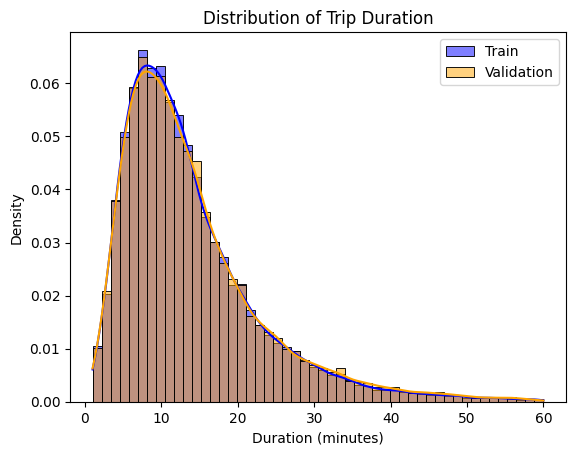

In [29]:
sns.histplot(df_train['duration'], color='blue', label='Train', kde=True, stat='density', bins=50)
sns.histplot(df_val['duration'], color='orange', label='Validation', kde=True, stat='density', bins=50)
plt.legend()
plt.xlabel('Duration (minutes)')
plt.ylabel('Density')
plt.title('Distribution of Trip Duration')
plt.show()

In [30]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df_train[categorical] = df_train[categorical].astype(str)
df_val[categorical] = df_val[categorical].astype(str)

In [ ]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df_train[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.0590084265576

In [34]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val = df_val[target].values
y_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred)

7.356800137089869